In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os



# Get the absolute path of the directory containing the module
module_dir = os.path.abspath('../../src')

# Add the directory to sys.path
sys.path.insert(0, module_dir)
#for path in sys.path:
#    print(path)

import PySaRLAC as sl
import random
import math
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as pyplot
random.seed(1234)

In [3]:
#For reference, this is the mapping between operator index and operator name
idx_op_map = ["PiPiGnd","PiPiExc","Sigma"]
op_idx_map = dict()
for i in range(len(op_idx_map)):
    op_idx_map[idx_op_map[i]] = i


In [5]:
f = h5py.File('../../../combined_data.hdf5','r')

f.keys()

<KeysViewHDF5 ['bdj_data', 'j_data']>

In [6]:
#These are the operator pairs in the data set
jdata = f['j_data']
con = jdata['contains']['entries']
for e in con.keys():
    op1 = con[e].attrs["first"][0]
    op2 = con[e].attrs["second"][0]
    print(op1,op2,idx_op_map[op1],idx_op_map[op2])

0 0 PiPiGnd PiPiGnd
0 1 PiPiGnd PiPiExc
0 2 PiPiGnd Sigma
1 1 PiPiExc PiPiExc
1 2 PiPiExc Sigma
2 2 Sigma Sigma


coeffs = [ alpha, beta, gamma ]

cor_new = [ [ coeffs[0]*coeffs[0]*orig_cor[0][0],   coeffs[0]*coeffs[1]*orig_cor[0][1], .... , ],
[...],
[...,    coeffs[2]*coeffs[2]*orig_cor[2][2] ] ]

In [7]:
#Lets get the jackknife data now
#we'll store just the upper triangular part of the correlator matrix
Lt=64
block_size = 8
nsample_unblocked = 741
nblock = nsample_unblocked // block_size
jdata = f['j_data']
jdata_cors = [ [None for j in range(3)] for i in range(3)] #3 ops
for i in range(3):
    for j in range(i,3):
        jdata_cors[i][j] = sl.CorrelationFunction(Lt)
        cdata = jdata['correlators']['m']["elem_%d_%d" % (i,j)]['series']
        for t in range(Lt):
            jvals = cdata["elem_%d" % t]['second'].attrs['data']
            assert len(jvals) == nblock
            jdist = sl.JackknifeDistribution(nblock)
            for s in range(nblock):
                jdist[s] = jvals[s]                        
            print(i,j,t,jdist)
            jdata_cors[i][j].setValue(t, jdist)
            jdata_cors[i][j].setCoord(t, float(t))

0 0 0 1720533968568.517334 +- 5152527015.142453
0 0 1 1308082730816.283691 +- 3838743441.830425
0 0 2 817893517712.709229 +- 2863212729.101227
0 0 3 546447262835.104431 +- 2279669730.728789
0 0 4 371442428617.719116 +- 1977207304.061023
0 0 5 255425904124.481415 +- 1755689182.491866
0 0 6 176186513933.533051 +- 1675816329.593119
0 0 7 121975341117.497650 +- 1675622507.859246
0 0 8 84486142123.333389 +- 1765400455.676582
0 0 9 58249791177.174446 +- 1879393121.904631
0 0 10 39940393601.323479 +- 1958523855.933918
0 0 11 27648826491.399117 +- 1990866054.886972
0 0 12 18821224075.937077 +- 2002394932.749103
0 0 13 12563605837.880201 +- 1979220601.150931
0 0 14 8421808271.079186 +- 1890603345.313394
0 0 15 6006876270.216669 +- 1801576701.302305
0 0 16 4230730202.962997 +- 1728716806.666870
0 0 17 3130040947.329866 +- 1666463901.359768
0 0 18 2141599622.018576 +- 1550578630.086805
0 0 19 1759634993.427925 +- 1447183512.452421
0 0 20 1391825459.095830 +- 1405494121.983228
0 0 21 1310339203.70

In [16]:
jdata_cors_2 = [[jdata_cors[0][0],jdata_cors[0][1]],[jdata_cors[0][1],jdata_cors[1][1]]]

alpha = 1
beta = 1
gamma = 1000

coeffs = [alpha, beta, gamma]
#print(type(jdata_cors[1][0]))

#jdata_cors

for i in range(3):
    for j in range(i,3):
        #print(i,j)
        jdata_cors[i][j] = jdata_cors[i][j]*coeffs[i]*coeffs[j]

    

#### Meeting Next Time

1) Write function to similpfy data storage and output (Done)
2) Remove Sigma op and do GEVP (Done)
3) Do 1x1 GEVP on (2) (Done)
4) Plots results to compare (Done)


1) Throw away 311 2pion op
2) Do 2x2 GEVP with 111 and sigma
3) Throw away sigma and do a 1x1 GEVP with 111 alone
4) Use rebasing to go from 2x2 -> 1x1
 
Expect: rebased 1x1 much better than 1x1 without sigma
Possible: rebased 1x1 better than 2x2

In [10]:
#For block double jackknife we expect a flattened array of size nblock * ( block_size*nblock - block_size ) = 66976
nouter_samp = nblock
ninner_samp = block_size*nblock - block_size
nunrolled= nouter_samp * ninner_samp
bdjdata = f['bdj_data']
bdjdata_cors = [ [None for j in range(3)] for i in range(3)]  #3 ops
for i in range(3):    
    for j in range(i,3):
        cdata = bdjdata['correlators']['m']["elem_%d_%d" % (i,j)]['series']   
        bdjdata_cors[i][j] = sl.CorrelationFunction(Lt)
        for t in range(Lt):
            jvals = np.array(cdata["elem_%d" % t]['second']['data']['unrolled_data'])
            assert len(jvals) == nunrolled
            jdist = sl.BlockDoubleJackknifeDistribution(nsample_unblocked, block_size)
            assert jdist.size() == nouter_samp and jdist[0].size() == ninner_samp
            u = 0
            for so in range(nouter_samp):
                jdist[so].sampleVector()[:] = jvals[u:u+ninner_samp]
                u+=ninner_samp
                #for si in range(ninner_samp):
                #    jdist[so][si] = jvals[u]
                #    u+=1
            print(i,j,t,jdist[0])
            bdjdata_cors[i][j].setValue(t, jdist)
            bdjdata_cors[i][j].setCoord(t, float(t))

0 0 0 1719845318663.085205 +- 3798209038.402640
0 0 1 1307820430212.833252 +- 2909128936.388778
0 0 2 817699872842.041504 +- 2226474219.047954
0 0 3 546388343762.084473 +- 1891743760.051520
0 0 4 371412451290.504578 +- 1709324819.823354
0 0 5 255402156926.810364 +- 1594969223.744068
0 0 6 176168180006.580048 +- 1544164369.009320
0 0 7 121926989500.236908 +- 1539336947.822167
0 0 8 84393148446.034088 +- 1553080940.401558
0 0 9 58106579984.547539 +- 1580894996.621566
0 0 10 39740757238.679298 +- 1596126764.802656
0 0 11 27458288311.910011 +- 1605923635.424059
0 0 12 18649288516.866985 +- 1586350433.657506
0 0 13 12436689759.691626 +- 1558205219.299251
0 0 14 8320147316.048739 +- 1516845796.658208
0 0 15 5940132342.937119 +- 1479817202.220709
0 0 16 4193917768.962172 +- 1449018489.926064
0 0 17 3090201649.459730 +- 1440240086.797071
0 0 18 2086592091.158474 +- 1426946471.970658
0 0 19 1667299566.862962 +- 1429892895.633361
0 0 20 1301633731.376409 +- 1435983835.335167
0 0 21 1202635314.52

In [11]:

test = sl.BlockDoubleJackknifeDistribution(741,8)
#bdjdata_cors[0][0].value(0)[0][729]
print(bdjdata_cors[0][0].value(0).shape())
print(nunrolled)

print(nblock)

[92, 728]
66976
92


/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/JackknifeDistribution.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  self.samples[i] = val
/var/folders/4j/pqzs8n79443gwsk673x7591h0000gn/T/ipykernel_48236/1815708685.py:104: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(eig_val_t1_t0[i][j]) - log(eig_val_t_t0[i][j])) #-log(A/B)


0.585506 +- 0.006946
[0.35544564 0.35078986 0.3489428  0.34883247 0.3472825  0.3448936
 0.34392168 0.3419605  0.33768252 0.33608056]


(0.0, 0.35544563935600076)

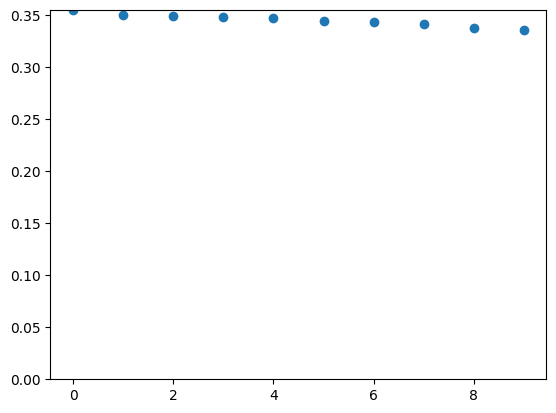

In [12]:
from scipy.linalg import eigh, eig
from numpy import log
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#print(jdata_cors[1][1].value(0).size())
#(jdata_cors[1][1].value(0)[0])




def gevp_eigv(data, t0, t):
    size = data[0][0].value(0).size()
    ev_result = [sl.JackknifeDistribution(size) for j in range(np.shape(data)[0])]  #Rename
    eigvec_result = np.zeros((size,3,3))
    #print(np.shape(eigvec_result))
    num_ops = np.shape(data)[0]
    Cmat = np.zeros((num_ops, num_ops), dtype=np.float64)
    Ct = np.zeros((num_ops, num_ops), dtype=np.float64)
    #print("Ct shape: ", np.shape(Ct))
    C_mats = np.zeros((size,3,3))
    C_t = np.zeros((size,3,3))
    for k in range(size):
        for i in range(np.shape(data)[0]):
            for j in range(np.shape(data)[0]):
                if i<=j:
                    Cmat[i][j] = data[i][j].value(t)[k]
                    Ct[i][j] = data[i][j].value(t0)[k]
                else:
                    Cmat[i][j] = data[j][i].value(t)[k]
                    Ct[i][j] = data[j][i].value(t0)[k]
        C_mats[k] = Cmat
        C_t[k] = Ct
        #try:
        eigvals, eigvecs = eig(Cmat, Ct)  #replace with eig package, see if all positive values
        idx = np.argsort(-eigvals) #Max eig value

        #sort both eigvals and eigvec
    
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:,idx]
            #print(eigvecs)
        #except np.linalg.LinAlgError:
            #eigvals = np.full(num_ops,np.nan) # Store failed matrix (Cmat and Ct) 3*3 matrix
        #    continue


        for m in range(num_ops):
            ev_result[m][k] = eigvals[m]
            eigvec_result[k][m] = eigvecs[m]

    return ev_result, eigvec_result, C_mats,C_t


def gevp_general(Ct, Cmat):

    eigvals, eigvecs = eig(Cmat, Ct)  #replace with eig package, see if all positive values
    idx = np.argsort(-eigvals) #Max eig value

    #sort both eigvals and eigvec

    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    return eigvals, eigvecs









def check_complex(gevp_val):
    t_min = 3
    t_max = 12
    for m in range(t_min,t_max-1):
        for n in range(m+1,t_max-1):
            for i in range(3):
                for j in range(3):
                    if np.imag(gevp_val(jdata_cors,n,m)[1][i][j].any()) < 1e-6:
                        pass
                    else:
                        print("Error, imag component")
                        break
    

def gevp(data, t0, t):
    ev_result = gevp_eigv(data, t0, t)[0]
    return ev_result


def eff_energy(data, t0, t, nth_state=None):
    size = data[0][0].value(0).size()
    eff_result = [sl.JackknifeDistribution(size) for j in range(np.shape(data)[0])]

    eig_val_t_t0 = gevp(data, t0, t)
    eig_val_t1_t0 = gevp(data, t0, t+1)

    for i in range(3):
        for j in range(size):
            # if log gives error return nan
            eff_result[i][j] = -(log(eig_val_t1_t0[i][j]) - log(eig_val_t_t0[i][j])) #-log(A/B)

    return eff_result 

#def new function of eff energy for specific state, compare implementations to check correctness, copy function above
#Check List:
# 1) Check if GEVP works for larger time for ground state (eig, isolating eff. energy func)
# 2) Rebased GEVP, check if V_ni elements are real, write code to check elements are real (Im(V)~0)


def rebased(C, eigvec):
    cov = np.zeros((3,3))
    #print(np.shape(eigvec))
    for i in range(3):
        for j in range(3):
            for i_in in range(3):
                for j_in in range(3):
                    cov[i][j] += eigvec[i,i_in] * C[i_in][j_in] * eigvec[j][j_in]

    return cov


def rebased1(C, eigvec):
    #print(np.shape(eigvec))
    return eigvec.conj().T @ C @ eigvec

#print(rebased(gevp_eigv(jdata_cors,3,8)[2][0],gevp_eigv(jdata_cors,3,8)[1]))
k_value = 90
ct = rebased1(gevp_eigv(jdata_cors,3,10)[2][k_value],gevp_eigv(jdata_cors,3,10)[1][k_value]) 
#ct = gevp_eigv(jdata_cors,3,8)[2][0]
ct0 = rebased1(gevp_eigv(jdata_cors,3,10)[3][k_value],gevp_eigv(jdata_cors,3,10)[1][k_value]) 
#ct0 = gevp_eigv(jdata_cors,3,8)[3][0]    
#print("Rebased shape: ", np.shape(ct))
result_rebased = gevp_general(ct0,ct)[1]
#print("eig vals", gevp_general(ct0,ct)[0])
#store C(t), C~(t)     
#E_eff = -(log(ev(t+1, t0)) - log(ev(t,t0)))
                 

        
    

print(eff_energy(jdata_cors,3,4)[1])
#print(gevp(jdata_cors,4,8)[0])



gs_energy = np.array([[] for _ in range(10)])

N = 10  
gs_energy = np.empty(N, dtype=object)

for i in range(N):
    gs_energy[i] = []  


n = 12                
for i in range(1,n):         
    for j in range(i + 1, n): 
        #print(j-i)
        if eff_energy(jdata_cors,i,j)[0][0] > 0:

            gs_energy[j-i-1].append(eff_energy(jdata_cors,i,j)[0][0])

for i in range(len(gs_energy)):
    if isinstance(gs_energy[i], list):
        gs_energy[i] = np.array(gs_energy[i])


averages = np.array([np.mean(subarr) for subarr in gs_energy])

print(averages)

t_vals = np.arange(0,len(averages))

def constant_func(x, a):
    return a 

#popt, pcov = curve_fit(constant_func, t_vals, averages)

#sum_i (1/E_i)*x_i <-- fit

#print("Fitted constant:", popt[0])

plt.scatter(t_vals,averages)

plt.ylim(0, max(averages))

#plot energy as func of time with errors, tabulate


In [10]:
from sympy import Matrix

Matrix(result_rebased)

Matrix([
[                 -1.0, -4.51680485437723e-16, -3.12482678123844e-16],
[-3.86645031806026e-31,                   1.0,  2.01783170603903e-16],
[-1.91614112638265e-15, -1.37382241978024e-15,                   1.0]])

/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:602: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx]


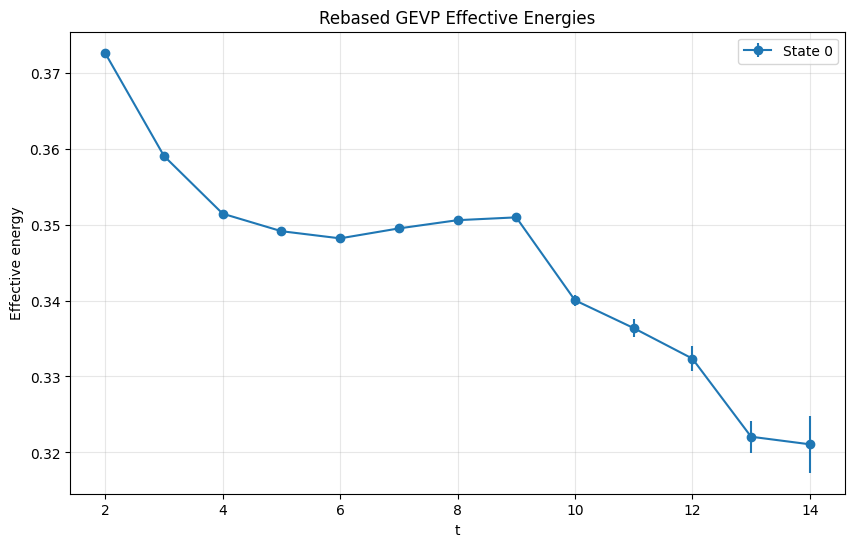

In [9]:
gevp = sl.GEVP4(jdata_cors)

# scan from t=2 up to t=15 with 2 rebasing steps
scan_results = gevp.rebasing_scan_all(N_times=2, t0=1, t_min=2, t_max=15)

# plot results
gevp.plot_eff_energies(scan_results)

<class 'list'>
0 : 40108128139.787621 +- 237331618.700151
1 : 31800863795.519833 +- 181295642.019829
2 : 14094170390.361801 +- 156921807.445609
3 : 6959920442.232809 +- 147206435.159816
4 : 3458102403.891766 +- 140041180.041890
5 : 1721543978.257097 +- 132598316.297877
6 : 825640860.303316 +- 132313723.754676
7 : 389276591.027109 +- 133712840.930838
8 : 155021828.181215 +- 139670001.210067
9 : -12942365.684627 +- 146199658.324762
10 : -99495987.713689 +- 151034592.112448
11 : -107988915.167547 +- 152317358.805075
12 : -124825488.357821 +- 150957179.558718
13 : -147782644.170124 +- 149259330.517496
14 : -150353754.177935 +- 144918555.504868
15 : -73223223.137678 +- 137710227.864148
16 : -50446939.070683 +- 134268939.907614
17 : -40203891.524056 +- 132649508.075274
18 : -21870013.003771 +- 126483387.462306
19 : -21716724.242210 +- 121664635.910940
20 : -48615952.935551 +- 120379151.178030
21 : -34923875.102743 +- 125692323.285443
22 : -43539111.522919 +- 135235920.352393
23 : -50401042.1

/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:267: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx]
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:253: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx2]
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:293: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(np.real(eig_val_t1_t0[j][i])/np.real(eig_val_t_t0[j][i]))) #-log(A/B)
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:254: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_vectors[i] = eigvecs[:,idx2]
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx]
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:99: ComplexWarning: 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:143: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(np.real(eig_val_t1_t0[j][i])/np.real(eig_val_t_t0[j][i]))) #-log(A/B)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


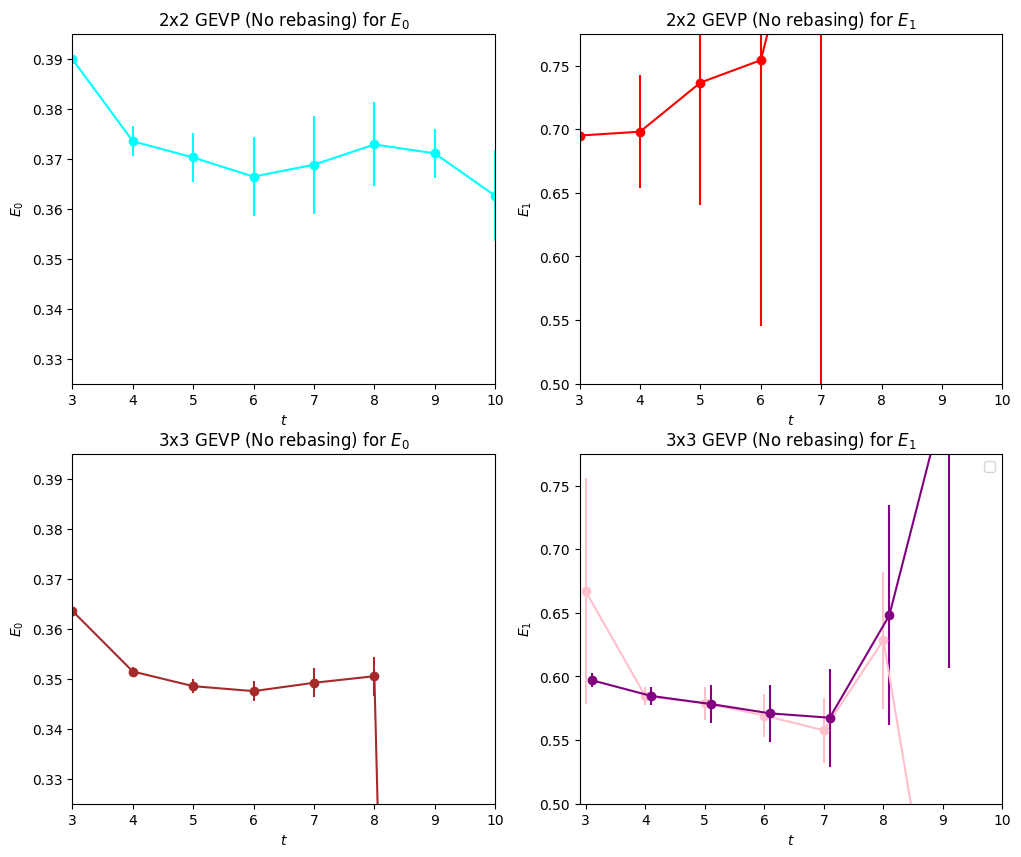

In [22]:
test1 = sl.GEVP_OG(jdata_cors_2)
test2 = sl.GEVP_OG(jdata_cors)
test3 = sl.GEVP(jdata_cors)
print(type(bdjdata_cors))

print(jdata_cors_2[1][1])

t_max = 15
t_min = 5

Dt = 3
Dt1 = 1

E_eff = []
E_eff_errors = []
E_eff1 = []
E_eff_errors1 = []
t_list = []
j_dists = []
j_dists0 = []
j_dists1 = []
j_dists2 = []
E_eff_rebased = []
E_eff_errors_rebased = []

strtest = False
strtest1 = True
energy_state = 0
t0_rebased_slice = 1 #keep in region with good statistics
t0_rebased_slice2 = 2
rebased_dt = 4
Eff_2 = []
Eff_2_errors = []
Eff_2_3by3 = []
Eff_2_errors_3by3 = []
###Make function that outputs mean, std, and dist for a given energy, use correlation func. object to store data
E_ff_3by3 = []
E_ff_errors_3by3 = []

def gevp_output(input_data, E_n, t_max, Dt, rebasing = False, rebased_time_slice = 1, rebased_Dt = 4):
    #time_array = np.arange(0, t_max)
    data = sl.CorrelationFunction(t_max)
    if rebasing == False:
        gevp_obj = sl.GEVP_OG(input_data)
        for i in range(0,t_max-1):
            for j in range(i+1, t_max):
                if j-i == Dt:
                    data.setValue(j, gevp_obj.run(i,j)[E_n])
                    data.setCoord(j, float(j))
        return  data
    if rebasing == True:
        gevp_obj = sl.GEVP(input_data)
        for i in range(0,t_max-1):
            for j in range(i+1, t_max):
                if j-i == Dt:
                    data.setValue(j, gevp_obj.run(i,j, rebased_time_slice, rebased_time_slice + 
                                                  rebased_Dt)[E_n])
                    data.setCoord(j, float(j))
        return data

gevp_test1 = gevp_output(jdata_cors, 1, 15, 3)

for i in range(0,t_max-1):
    for j in range(i+1, t_max):
        if j-i == Dt:
        
            #print(f"t0={i}, t={j}, E_{energy_state}={test1.run(0,i,j,sorted=strtest)[energy_state].mean()}")
            t_list.append(j)
            E_eff.append(test1.run(i,j)[energy_state].mean()) #Change params to Dt and t0
            E_eff_errors.append(test1.run(i,j)[energy_state].standardError())
            Eff_2.append(test1.run(i,j)[energy_state+1].mean()) #Change params to Dt and t0
            Eff_2_errors.append(test1.run(i,j)[energy_state+1].standardError())
            Eff_2_3by3.append(test2.run(i,j)[energy_state+1].mean()) #Change params to Dt and t0
            Eff_2_errors_3by3.append(test2.run(i,j)[energy_state+1].standardError())
            E_ff_3by3.append(test2.run(i,j)[energy_state].mean()) #Change params to Dt and t0
            E_ff_errors_3by3.append(test2.run(i,j)[energy_state].standardError())
            E_eff_rebased.append(test3.run(i,j,t0_rebased_slice,t0_rebased_slice+rebased_dt)[energy_state+1].mean()) #Change params to Dt and t0
            E_eff_errors_rebased.append(test3.run(i,j,t0_rebased_slice,t0_rebased_slice+rebased_dt)[energy_state+1].standardError())
            #E_eff1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].mean())
            #E_eff_errors1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].standardError())
            #j_dists.append(test1.run(0,i,j,sorted=strtest)[energy_state])
            j_dists0.append(test2.run(i,j)[energy_state+1].sampleVector())
            #j_dists1.append(test1.run(0,i,j, sorted=strtest1)[energy_state].sampleVector())
            #j_dists2.append(test2.run(0,i,j,sorted=strtest)[energy_state])
            #print(test2.run(0,i,j,sorted=strtest)[energy_state].mean())
            #j_dists1.append(test1.run(0,i,j)[1].sampleVector())

for i in range(t_max-1):
    for j in range(i+1, t_max):
        if j-i == Dt1:
            pass
            #j_dists1.append(test1.run(0,i,j,strtest)[1].sampleVector())

fig, axes = plt.subplots(2,2, figsize=(12,10))

graph2 = False
#plt.scatter(np.array(t_list)+0.1,E_eff, label=f"t0={t0_rebased_slice}")
#plt.scatter(t_list,Eff_2, label=f"t0={t0_rebased_slice2}")
axes[0,0].set_xlim((Dt,10))
axes[0,0].set_ylim((0.325,0.395))
axes[0,0].set_ylabel(fr"$E_{energy_state}$")
axes[0,0].set_xlabel(r"$t$")

axes[0,1].set_xlim((Dt,10))
axes[0,1].set_ylim((0.5,0.775))
axes[0,1].set_ylabel(fr"$E_{energy_state+1}$")
axes[0,1].set_xlabel(r"$t$")

axes[0,0].errorbar(t_list, E_eff, np.abs(E_eff_errors),marker='o',color="cyan")
axes[0,1].errorbar(np.array(t_list), Eff_2, np.abs(Eff_2_errors),marker='o', color="red")


axes[1,1].set_xlim((Dt-0.1,10))
axes[1,1].set_ylim((0.5,0.775))
axes[1,1].set_ylabel(fr"$E_{energy_state+1}$")
axes[1,1].set_xlabel(r"$t$")

axes[1,0].set_xlim((Dt,10))
axes[1,0].set_ylim((0.325,0.395))
axes[1,0].set_ylabel(fr"$E_{energy_state}$")
axes[1,0].set_xlabel(r"$t$")

axes[0,0].set_title(r"2x2 GEVP (No rebasing) for $E_0$")
axes[0,1].set_title(r"2x2 GEVP (No rebasing) for $E_1$")
axes[1,0].set_title(r"3x3 GEVP (No rebasing) for $E_0$")
axes[1,1].set_title(r"3x3 GEVP (No rebasing) for $E_1$")

axes[1,0].errorbar(np.array(t_list), E_ff_3by3, np.abs(E_ff_errors_3by3),marker='o', color="brown")
axes[1,1].errorbar(np.array(t_list), Eff_2_3by3, np.abs(Eff_2_errors_3by3),marker='o', color="pink")
axes[1,1].errorbar(np.array(t_list)+0.1, E_eff_rebased, np.abs(E_eff_errors_rebased),marker='o', color= "purple")


if graph2 == True:
    plt.scatter(t_list,E_eff1, label="Eigen Sort")
    plt.errorbar(t_list, E_eff1, np.abs(E_eff_errors1))
plt.legend()




#tabulate Dt, errors, platteau regions, take jackknife difference with other data points and determine whether its results in excited state contamination
#Look at energy of first excited state
#Alogirthm with sorts based  on inner product with previous/first vectors in gevp
#Histogram of jackknife distribution at t = 9, Dt = 5, E_1. (Split distribution), plt.hist() with JackknifeDistribution.sampleVector()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

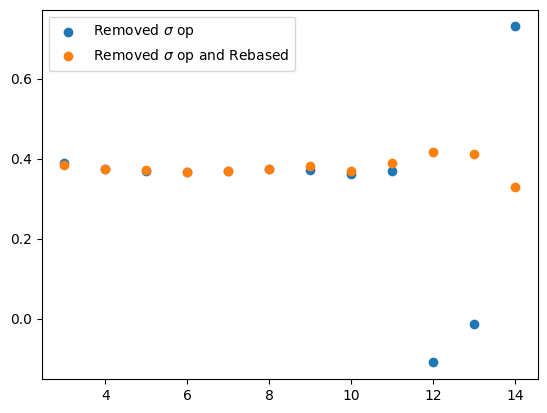

In [27]:
gevp_without_sigma = gevp_output(jdata_cors_2, 0, 15, 3)

gevp_without_sigma_rebased = gevp_output(jdata_cors_2, 0, 15, 3, rebasing=True)

plt.scatter(*gevp_without_sigma.plotInputs()[:2], label = r"Removed $\sigma$ op")
plt.scatter(*gevp_without_sigma_rebased.plotInputs()[:2], label = r"Removed $\sigma$ op and Rebased")
plt.legend()

<class 'list'>


/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx]
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_values[i] = eigvals[idx2]
/Users/clementcharles/Documents/PySARLaC/src/PySaRLAC/GEVP.py:143: RuntimeWarning: invalid value encountered in log
  eff_result[i][j] = -(log(np.real(eig_val_t1_t0[j][i])/np.real(eig_val_t_t0[j][i]))) #-log(A/B)


12


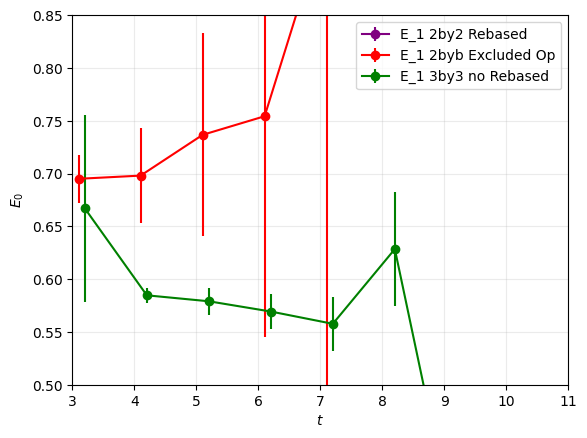

In [ ]:
test1 = sl.GEVP(jdata_cors)
test2 = sl.GEVP2(bdjdata_cors)
print(type(bdjdata_cors))
#print(test1.run(1,4,10)[1])

t_max = 15
t_min = 5

Dt = 3
Dt1 = 1

E_eff_rebased = []
E_eff_errors_rebased = []
E_eff1 = []
E_eff_errors1 = []
t_list = []
j_dists = []
j_dists0 = []
j_dists1 = []
j_dists2 = []

strtest = False
strtest1 = True
energy_state = 0
t0_rebased_slice = 2 #keep in region with good statistics
t0_rebased_slice2 = 2
rebased_dt = 1
#Eff_2 = []
#Eff_2_errors = []
for i in range(0,t_max-1):
    for j in range(i+1, t_max):
        if j-i == Dt:
        
            #print(f"t0={i}, t={j}, E_{energy_state}={test1.run(0,i,j,sorted=strtest)[energy_state].mean()}")
            t_list.append(j)
            E_eff_rebased.append(test1.run(i,j,t0_rebased_slice,t0_rebased_slice+rebased_dt)[energy_state].mean()) #Change params to Dt and t0
            E_eff_errors_rebased.append(test1.run(i,j,t0_rebased_slice,t0_rebased_slice+rebased_dt)[energy_state].standardError())
            #Eff_2.append(test1.run(i,j,t0_rebased_slice2,t0_rebased_slice2+rebased_dt)[energy_state].mean()) #Change params to Dt and t0
            #Eff_2_errors.append(test1.run(i,j,t0_rebased_slice2,t0_rebased_slice2+rebased_dt)[energy_state].standardError())
            #E_eff1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].mean())
            #E_eff_errors1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].standardError())
            #j_dists.append(test1.run(0,i,j,sorted=strtest)[energy_state])
            #j_dists0.append(test1.run(0,i,j,sorted=strtest)[energy_state].sampleVector())
            #j_dists1.append(test1.run(0,i,j, sorted=strtest1)[energy_state].sampleVector())
            #j_dists2.append(test2.run(0,i,j,sorted=strtest)[energy_state])
            #print(test2.run(0,i,j,sorted=strtest)[energy_state].mean())
            #j_dists1.append(test1.run(0,i,j)[1].sampleVector())

for i in range(t_max-1):
    for j in range(i+1, t_max):
        if j-i == Dt1:
            pass
            #j_dists1.append(test1.run(0,i,j,strtest)[1].sampleVector())

graph2 = False
#plt.scatter(np.array(t_list)+0.1,E_eff, label=f"t0={t0_rebased_slice}")
#plt.scatter(t_list,Eff_2, label=f"t0={t0_rebased_slice2}")
plt.xlim((Dt,11))
#plt.ylim((0.325,0.375))
#plt.ylim((0.50,0.85))
plt.ylabel(fr"$E_{energy_state}$")
plt.xlabel(r"$t$")
print(len(Eff_2))
plt.errorbar(t_list, E_eff_rebased, np.abs(E_eff_errors_rebased),marker='o', color= "purple", label = "E_1 2by2 Rebased")
#plt.errorbar(np.array(t_list)+0.1, Eff_2, np.abs(E_eff_errors),marker='x')
plt.errorbar(np.array(t_list)+0.1, Eff_2, np.abs(Eff_2_errors),marker='o', color="red", label = "E_1 2byb Excluded Op")
#plt.errorbar(np.array(t_list)+0.1, Eff_2, np.abs(Eff_2_errors),marker='o')
plt.errorbar(np.array(t_list)+0.2, Eff_2_3by3, np.abs(Eff_2_errors_3by3),marker='o', color="green", label="E_1 3by3 no Rebased")

if graph2 == True:
    plt.scatter(t_list,E_eff1, label="Eigen Sort")
    plt.errorbar(t_list, E_eff1, np.abs(E_eff_errors1))
plt.legend()

plt.grid(True, alpha=0.25)


#tabulate Dt, errors, platteau regions, take jackknife difference with other data points and determine whether its results in excited state contamination
#Look at energy of first excited state
#Alogirthm with sorts based  on inner product with previous/first vectors in gevp
#Histogram of jackknife distribution at t = 9, Dt = 5, E_1. (Split distribution), plt.hist() with JackknifeDistribution.sampleVector()


(array([2., 0., 1., 0., 4., 2., 3., 4., 8., 3., 3., 6., 7., 7., 8., 8., 6.,
        6., 0., 2., 3., 2., 3., 0., 1., 0., 2., 0., 0., 1.]),
 array([0.58294745, 0.58307698, 0.58320651, 0.58333605, 0.58346558,
        0.58359511, 0.58372464, 0.58385417, 0.58398371, 0.58411324,
        0.58424277, 0.5843723 , 0.58450183, 0.58463137, 0.5847609 ,
        0.58489043, 0.58501996, 0.58514949, 0.58527903, 0.58540856,
        0.58553809, 0.58566762, 0.58579715, 0.58592669, 0.58605622,
        0.58618575, 0.58631528, 0.58644481, 0.58657435, 0.58670388,
        0.58683341]),
 <BarContainer object of 30 artists>)

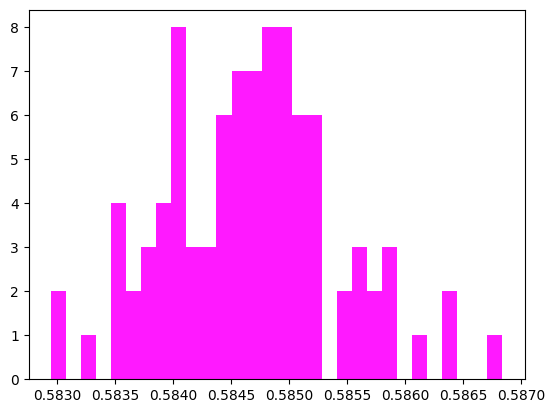

In [ ]:
plt.hist(j_dists0[],bins=30, label=r"State sorted", alpha=0.9, color="magenta")

[[-9.99989975e-01 -3.81864394e-04  4.46143332e-03]
 [ 9.99943049e-01 -7.22388455e-03  7.85587229e-03]]

In [11]:
"""
test2 = sl.GEVP2(bdjdata_cors)

t_max = 15
t_min = 5

Dt = 3
Dt1 = 1

E_eff = []
E_eff_errors = []
E_eff1 = []
E_eff_errors1 = []
t_list = []
j_dists = []
j_dists0 = []
j_dists1 = []

strtest = False
strtest1 = True
energy_state = 1
for i in range(0,t_max-1):
    for j in range(i+1, t_max):
        if j-i == Dt:
    
            t_list.append(j)
            E_eff.append(test2.run(0,i,j,sorted=strtest)[energy_state].mean())
            E_eff_errors.append(test1.run(0,i,j,sorted=strtest)[energy_state].standardError())
            E_eff1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].mean())
            E_eff_errors1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].standardError())
            j_dists.append(test1.run(0,i,j,sorted=strtest)[energy_state])
            j_dists0.append(test1.run(0,i,j,sorted=strtest)[energy_state].sampleVector())
            j_dists1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].sampleVector())
            #j_dists1.append(test1.run(0,i,j)[1].sampleVector())

for i in range(t_max-1):
    for j in range(i+1, t_max):
        if j-i == Dt1:
            pass
            #j_dists1.append(test1.run(0,i,j,strtest)[1].sampleVector())

graph2 = True
plt.scatter(t_list,E_eff, label="No Eigen Sort")
plt.xlim((Dt,11))
plt.ylim((0.40,0.80))
plt.ylabel(fr"$E_{energy_state}$")
plt.xlabel(r"$t$")

plt.errorbar(t_list, E_eff, np.abs(E_eff_errors))

if graph2 == True:
    plt.scatter(t_list,E_eff1, label="Eigen Sort")
    plt.errorbar(t_list, E_eff1, np.abs(E_eff_errors1))
plt.legend()
"""

'\ntest2 = sl.GEVP2(bdjdata_cors)\n\nt_max = 15\nt_min = 5\n\nDt = 3\nDt1 = 1\n\nE_eff = []\nE_eff_errors = []\nE_eff1 = []\nE_eff_errors1 = []\nt_list = []\nj_dists = []\nj_dists0 = []\nj_dists1 = []\n\nstrtest = False\nstrtest1 = True\nenergy_state = 1\nfor i in range(0,t_max-1):\n    for j in range(i+1, t_max):\n        if j-i == Dt:\n    \n            t_list.append(j)\n            E_eff.append(test2.run(0,i,j,sorted=strtest)[energy_state].mean())\n            E_eff_errors.append(test1.run(0,i,j,sorted=strtest)[energy_state].standardError())\n            E_eff1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].mean())\n            E_eff_errors1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].standardError())\n            j_dists.append(test1.run(0,i,j,sorted=strtest)[energy_state])\n            j_dists0.append(test1.run(0,i,j,sorted=strtest)[energy_state].sampleVector())\n            j_dists1.append(test1.run(0,i,j,sorted=strtest1)[energy_state].sampleVector())\n          

0.34182058302661444


Text(0, 0.5, 'Frequency')

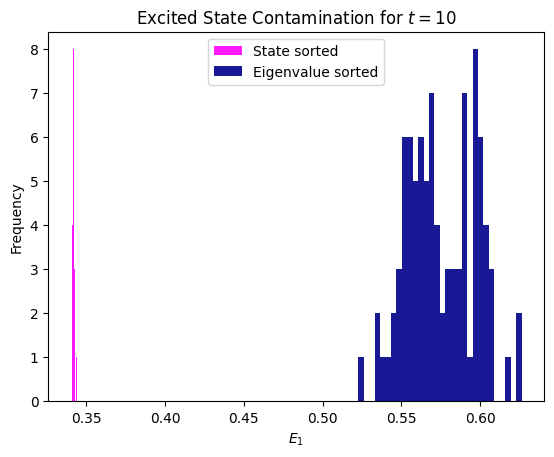

In [12]:
#Histogram of jackknife distribution at t = 9, Dt = 5, E_1. (Split distribution), plt.hist() with JackknifeDistribution.sampleVector()

print(j_dists[7].mean())
#print(j_dists1[9].mean())
time = 10
plt.hist(j_dists0[time-Dt],bins=30, label=r"State sorted", alpha=0.9, color="magenta")
plt.hist(j_dists1[time-Dt],bins=30, label=r"Eigenvalue sorted",alpha=0.9,color="darkblue")
plt.title(fr"Excited State Contamination for $t={time}$")
plt.legend()
plt.xlabel(r"$E_1$")
plt.ylabel("Frequency")

In [13]:
import numpy as np
from numpy.linalg import norm

def sortVector1(V):
    for i in range(len(V)):
        for j in range(i+1,len(V)):
            #print(i,j)
            print(np.dot(V[i]/norm(V[i]),V[j]/norm(V[j])))

def sortVector(V_init, V_current):

    sorted_vecs = np.empty(len(V_current), dtype=object)
    if V_init != None:
        for i, v_i in enumerate(V_init):
            overlaps = [np.dot(v_i/norm(v_i), v/norm(v)) for v in V_current]
            max_index = np.argmax(overlaps)
            sorted_vecs[i] = max_index
    else:
        sorted_vecs = idx

    return sorted_vecs



sortVector([[1,2,3],[1.2,2,3],[1,2,3.6]],[[1.2,2.05,3],[1,2,3],[1,2,3.6]])

array([1, 0, 2], dtype=object)

In [14]:
print(type(j_dists[0]))

Lt = len(j_dists)
jack_correlation = sl.CorrelationFunction(Lt)
dd_jack = sl.CorrelationFunction(Lt)
for t0 in range(0,Lt):
    t = t0 + Dt
    jack_correlation.setCoord(t0, float(t))
    #print(j_dists[t])
    jack_correlation.setValue(t0, j_dists[t0])
    dd_jack.setCoord(t0, float(t0))
    dd_jack.setValue(t0, j_dists2[t0])

print(jack_correlation)
#data_fold = raw.fold()

<class 'PySaRLAC.JackknifeDistribution.JackknifeDistribution'>
3.0 : 0.666988 +- 0.088807
4.0 : 0.584667 +- 0.007123
5.0 : 0.579022 +- 0.012861
6.0 : 0.569309 +- 0.016711
7.0 : 0.557685 +- 0.025603
8.0 : 0.628463 +- 0.053808
9.0 : 0.350706 +- 0.004111
10.0 : 0.341821 +- 0.006513
11.0 : 0.335905 +- 0.015680
12.0 : 0.325560 +- 0.043239
13.0 : 0.236515 +- 0.261316
14.0 : -0.481123 +- 0.602811



In [15]:
fitfunc = sl.FitConstant()
N = j_dists[0].size()
fitter = sl.Fitter(fitfunc)
fit_start = 1
fit_end = 5
#jack = raw.resample(sl.JackknifeDistribution)
#djack = raw.resample(sl.DoubleJackknifeDistribution)
#djack_inrange = djack.sliceRange(fit_start,fit_end)
jack_inrange = jack_correlation.sliceRange(fit_start,fit_end) #slicing by index
dd_jack_inrange = dd_jack.sliceRange(fit_start,fit_end)
cov = sl.CorrelationFunction.covariance(jack_inrange, jack_inrange)
cov_jack = [  [ sl.JackknifeDistribution(N, cov[i][j]) for j in range(len(cov)) ] for i in range(len(cov)) ]
#fitter.setCovarianceMatrix(cov_jack)
fitter.generateCovarianceMatrix(dd_jack_inrange)
#print(cov_jack[0][0])


In [16]:

print(fitter.cov[2][2])

print(N)

params = [sl.JackknifeDistribution(N, 0.38)]
chisq, dof = fitter.fit(params, jack_inrange)
print(params[0], chisq/float(dof))
#print(jack_inrange.size())

0.000243 +- 0.000108
92
Performing a fit with 1 free parameters and 4 degrees of freedom
0.581966 +- 0.008118 1.365723 +- 1.123362


E_1:  0.5819662402591343 +/- 0.007122721919830006
4.0 : 0.584667 +- 0.007123
5.0 : 0.579022 +- 0.012861
6.0 : 0.569309 +- 0.016711
7.0 : 0.557685 +- 0.025603
8.0 : 0.628463 +- 0.053808



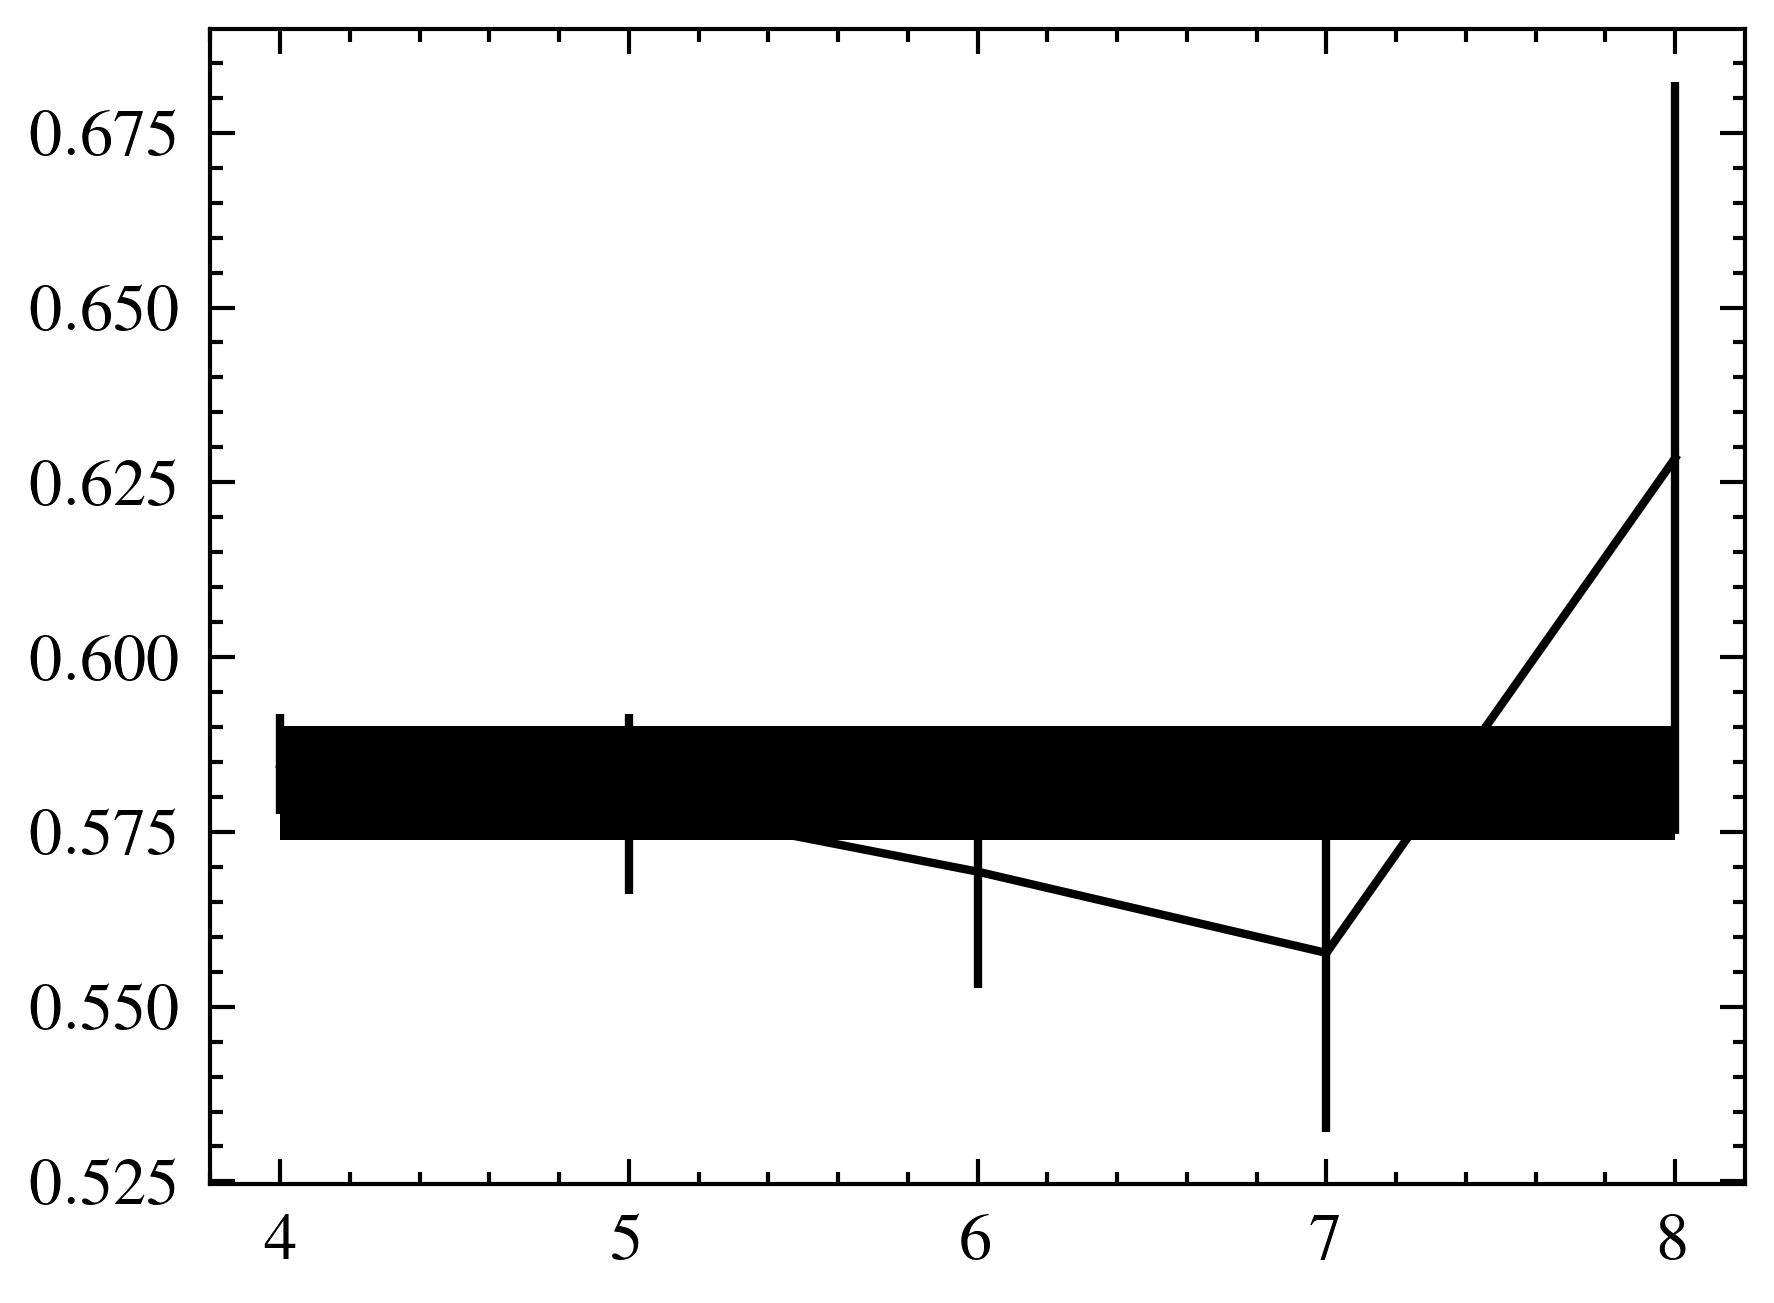

In [ ]:

import scienceplots

fit_y = sl.evaluateFitFunc(fitfunc,jack_inrange,params)
plot_data = jack_inrange.plotInputs()
plot_result = fit_y.plotInputs()
print(rf"E_{energy_state}:  {plot_result[1][0]} +/- {plot_data[2][0]}")
with open('data_samp.txt', 'a') as file:
    file.write(f"E_{energy_state}:  {plot_result[1][0]} +/- {plot_data[2][0]} range t: ({fit_start}, {fit_end}) Dt: {Dt}\n")

print(jack_inrange)
pyplot.rcParams['text.usetex'] = True
pyplot.style.use(['science', 'ieee'])
pyplot.errorbar(plot_data[0],plot_data[1],yerr=plot_data[2])
pyplot.fill_between(plot_result[0],plot_result[1]-plot_result[2],plot_result[1]+plot_result[2])
pyplot.savefig(f"GEVP_plot_Dt_{Dt}_t_range({fit_start},{fit_end})_(E_{energy_state}).pdf")

#make Error block transparent (alpha=0.3), add marker, plot range, plot without line
#pyplot.xlim(0,6)



#sorting, helps with error bars, check overlaps with inital vector (no too similar)
#Do unfrozen fit with djack
#generate plots for multiple values of Dt regular GEVP to 4 sig-figs. Some tables likely of (Energy) fitting data and the choices made Dt, t_min, t_max, potential fix t_max and scan over t_min
#Rebasing, etc
#Take jackknife differences

In [18]:
%pip install SciencePlots

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
from itertools import product

# Suppose we have a 3D array
arr = np.arange(2 * 3 * 4).reshape(2, 3, 4)

# List of dimensions (shape of the array)
N_list = list(arr.shape)[:2]
print(N_list)
# Iterate over all indices
for idx in product(*[range(N) for N in [1,2]]):
    print(f"Index: {idx}, Value: {arr[idx][1]}")

[2, 3]
Index: (0, 0), Value: 1
Index: (0, 1), Value: 5
